# Dataset Statistics/exploration (Safe to run, better run one time)

Try to understand the quality of the data better. 
In total five types of data:

    1. DMD patterns 
    2. Chromox real beam
    3. YAG real beam
    4. Chromox laser scan
    5. Yag laser scan

Beam data started from Wednesday (Chromox) (2025-11-19), then fiber state changed, then Friday and Saturday (Chromox, 2025-11-21 + 2025-11-22), Sunday (YAG, 2025-11-23), with laser scan also in Saturday and Sunday, plus DMD in the middle of sections (Many collected in 2025-11-20)


In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)   # go one level up
print(os.getcwd())         

from xflow import SqlProvider, flow, consume, TransformRegistry as T
from xflow.utils import plot_image
import xflow.extensions.physics
from xflow.utils.io import scan_files, create_directory
from xflow.utils.sql import union_sqlite_db_tables, merge_sqlite_dbs
from xflow.extensions.physics.beam import extract_beam_parameters

from config_utils import load_config, detect_machine
from utils import *

from functools import partial
import pandas as pd
import numpy as np
import sqlite3
import json
from PIL import Image
from tqdm import tqdm


experiment_name = "CAE_validate_clear"  
machine = detect_machine() 

config = load_config(
    f"{experiment_name}.yaml",
    machine=machine
)

# if win, windows test in machine then auto switch to windows path, otherwise use mac path
if any(win in machine for win in ["win", "windows"]): # windows
    dirs = {
        "merged_db_path": "C:/Users/qiyuanxu/Desktop/clear_2025_dataset.db",
        "raw_db_dir": "C:/Users/qiyuanxu/Documents/DataHub/datasets",
        "final_merged_db_path": "C:/Users/qiyuanxu/Desktop/dataset_meta.db",
        "output_dataset_dir": "C:/Users/qiyuanxu/Desktop/CLEAR25_DMD/dataset/",
        "output_db_dir": "C:/Users/qiyuanxu/Desktop/CLEAR25_DMD/db/dataset_meta.db"
    }
elif any(mac in machine for mac in ["mac", "darwin"]): # Mac
    dirs = {
        "merged_db_path": "/Users/andrewxu/Desktop/clear_2025_dataset.db",
        "raw_db_dir": "/Users/andrewxu/Documents/DataHub/datasets",
        "final_merged_db_path": "/Users/andrewxu/Desktop/dataset_meta.db",
        "output_dataset_dir": "/Users/andrewxu/Desktop/CLEAR25_DMD/dataset/",
        "output_db_dir": "/Users/andrewxu/Desktop/CLEAR25_DMD/db/dataset_meta.db"
    }
else:
    raise ValueError(f"Unsupported machine: {machine}")

c:\Users\qiyuanxu\Documents\GitHub\fiber-image-reconstruction-comparison
[config_utils] Using machine profile: win-qiyuanxu


# Scope 1 - DMD synthetic data and its corresponding Real data

Create such ready to use dataset for training and evaluation (could reverse the training testing logic)

In [2]:
# ============================
# Merge entire CLEAR 2025 dataset in to a single database
# ============================
db_paths = scan_files(dirs["raw_db_dir"], extensions=[".db"], return_type="str")
merge_sqlite_dbs(db_paths, output_path=dirs["merged_db_path"], source_column="db_path")

# ============================
# Left join metadata into the big merged database to form a single complete table
# ============================
sql = """
SELECT
    d.*,
    c.experiment_description,
    c.image_source,
    c.image_device,
    c.fiber_config,
    c.camera_config,
    c.other_config
FROM mmf_dataset_metadata AS d
LEFT JOIN mmf_experiment_config AS c
  ON c.id = d.config_id
 AND c.db_path = d.db_path;
"""

with sqlite3.connect(str(dirs["merged_db_path"])) as con:
    tables_df = pd.read_sql_query(sql, con)

# optional: drop duplicate column names (e.g. both tables have "id", "db_path")
tables_df = tables_df.loc[:, ~tables_df.columns.duplicated()]
print(tables_df.shape)

C:\Users\qiyuanxu\Documents\GitHub\XFlow\src\xflow\utils\sql.py:511: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df = pd.concat(dfs, ignore_index=True)


(93787, 31)


In [3]:
# ============================
# DMD hourly data collection statistics
# ============================

def hourly_counts(df: pd.DataFrame) -> pd.DataFrame:
    """Aggregate rows by hour and return counts sorted chronologically."""
    return (
        pd.to_datetime(df["create_time"], errors="coerce")
          .dt.strftime("%Y-%m-%d %H")
          .dropna()
          .value_counts()
          .rename_axis("hour")
          .reset_index(name="count")
          .sort_values("hour")
          .reset_index(drop=True)
    )

tables_df["other_config"] = tables_df["other_config"].map(
    lambda x: x if isinstance(x, dict)
    else json.loads(x) if isinstance(x, str) and x.strip().startswith("{")
    else None
)

mask = tables_df["other_config"].map(
    lambda d: (
        isinstance(d, dict)
        and d.get("dmd_config", {}).get("type") != "DummyDMD"
        and d.get("beam_settings") is None
    )
)

dmd_df = tables_df.loc[mask].copy()
print("Total rows kept:", int(mask.sum()))

out = hourly_counts(dmd_df)
out

Total rows kept: 10337


,hour,count
0,2025-11-19 16,225
1,2025-11-19 17,891
2,2025-11-20 06,25
3,2025-11-20 07,1096
4,2025-11-20 08,1436
5,2025-11-20 10,434
6,2025-11-20 11,2432
7,2025-11-20 12,173
8,2025-11-20 19,558
9,2025-11-20 20,394


In [4]:
# ============================
# Chromox hourly data collection statistics
# ============================
mask = tables_df["beam_settings"].notna() & tables_df["image_device"].astype(str).str.contains("Chromox", na=False)
chromox_df = tables_df.loc[mask].copy()
print("Total rows kept:", int(mask.sum()))

out = hourly_counts(chromox_df)
out

Total rows kept: 49583


,hour,count
0,2025-11-19 12,326
1,2025-11-19 13,35
2,2025-11-19 14,785
3,2025-11-19 15,1842
4,2025-11-21 08,28
5,2025-11-21 09,4407
6,2025-11-21 10,4836
7,2025-11-21 11,247
8,2025-11-21 22,2913
9,2025-11-21 23,5047


In [5]:
# ============================
# Yag hourly data collection statistics
# ============================
mask = tables_df["beam_settings"].notna() & tables_df["image_device"].astype(str).str.contains("YAG", na=False)
yag_df = tables_df.loc[mask].copy()
print("Total rows kept:", int(mask.sum()))

out = hourly_counts(yag_df)
out

Total rows kept: 15341


,hour,count
0,2025-11-23 09,1954
1,2025-11-23 10,3648
2,2025-11-23 11,3406
3,2025-11-23 12,4694
4,2025-11-23 13,1639


# Merge/Compile target .db then based on the .db create the final dataset
First select the data we want, compile to a single .db, create a column with abs path to samples, build datapipeline and go though this .db, keep the structure and save as a new ready to train folder
1. DMD only validation
2. If 1 works, DMD training + Chromox validation
3. There's two setup of MMF, one before 2025-11-20, one after. We do one after first
4. Figure out crop position

In general the valid DMD + Chromox as one 

In [6]:
core_col_mmf_dataset_metadata = ["image_id", "is_calibration", "batch", "purpose", "db_path", "image_path", "comments", "beam_settings",
                                 "create_time", "is_saturated_ground_truth", "is_saturated_fiber_output", "config_id"]
core_col_mmf_experiment_config = ["experiment_description", "image_source", "image_device", "camera_config", "other_config"]

"""
 '2025-11-19',                          # dataset 1
 '2025-11-20',
 '2025-11-20_DMD_for_Wednesday_1',      # dataset 1
 '2025-11-20_DMD_for_Wednesday_2',      # dataset 1
 '2025-11-21',
 '2025-11-21-morning',
 '2025-11-22',
 '2025-11-22-afternoon',
 '2025-11-22-morning'
"""

df_to_merge = [dmd_df] # dmd_df, chromox_df, yag_df

final_df = pd.concat(df_to_merge, ignore_index=True, copy=False)
final_df = final_df.loc[:, [c for c in core_col_mmf_dataset_metadata + core_col_mmf_experiment_config if c in final_df.columns]]
base = final_df["db_path"].fillna("").str.rsplit("/", n=2).str[0] + "/"
final_df["image_path"] = base + final_df["image_path"].fillna("").str.lstrip("/")
final_df["dataset"] = final_df["db_path"].astype(str).str.rsplit("/", n=3).str[-3]
final_df = final_df.drop(columns=["db_path"])

remove_datasets = ['2025-11-19','2025-11-20_DMD_for_Wednesday_1','2025-11-20_DMD_for_Wednesday_2']
final_df = final_df[~final_df["dataset"].isin(remove_datasets)].copy()
final_df

,image_id,is_calibration,batch,purpose,image_path,comments,beam_settings,create_time,is_saturated_ground_truth,is_saturated_fiber_output,config_id,experiment_description,image_source,image_device,camera_config,other_config,dataset
1116,1763666411919432700,0,1,training,C:/Users/qiyuanxu/Documents/DataHub/datasets/2...,test dmd,None,2025-11-20 19:20:11,0,0,1,2d multi-gaussian distributions simulation,simulation,dmd,"{""ground_truth_camera_exposure"": 195000.0, ""gr...","{'dmd_config': {'bit_depth': 8, 'picture_time'...",2025-11-20
1117,1763666430727639900,0,2,training,C:/Users/qiyuanxu/Documents/DataHub/datasets/2...,test dmd,None,2025-11-20 19:20:30,0,0,1,2d multi-gaussian distributions simulation,simulation,dmd,"{""ground_truth_camera_exposure"": 195000.0, ""gr...","{'dmd_config': {'bit_depth': 8, 'picture_time'...",2025-11-20
1118,1763666431750181300,0,2,training,C:/Users/qiyuanxu/Documents/DataHub/datasets/2...,test dmd,None,2025-11-20 19:20:31,0,0,1,2d multi-gaussian distributions simulation,simulation,dmd,"{""ground_truth_camera_exposure"": 195000.0, ""gr...","{'dmd_config': {'bit_depth': 8, 'picture_time'...",2025-11-20
1119,1763666432738996700,0,2,training,C:/Users/qiyuanxu/Documents/DataHub/datasets/2...,test dmd,None,2025-11-20 19:20:32,0,0,1,2d multi-gaussian distributions simulation,simulation,dmd,"{""ground_truth_camera_exposure"": 195000.0, ""gr...","{'dmd_config': {'bit_depth': 8, 'picture_time'...",2025-11-20
1120,1763666433745388100,0,2,training,C:/Users/qiyuanxu/Documents/DataHub/datasets/2...,test dmd,None,2025-11-20 19:20:33,0,0,1,2d multi-gaussian distributions simulation,simulation,dmd,"{""ground_truth_camera_exposure"": 195000.0, ""gr...","{'dmd_config': {'bit_depth': 8, 'picture_time'...",2025-11-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10332,1763846135287353800,0,11,training,C:/Users/qiyuanxu/Documents/DataHub/datasets/2...,CLEAR beamtime; ND filter 3; DMD data,None,2025-11-22 21:15:35,0,1,6,local real beam image for evaluation,e-beam,dmd,"{""ground_truth_camera_exposure"": 195000.0, ""gr...","{'dmd_config': {'bit_depth': 8, 'picture_time'...",2025-11-22
10333,1763846135880102500,0,11,training,C:/Users/qiyuanxu/Documents/DataHub/datasets/2...,CLEAR beamtime; ND filter 3; DMD data,None,2025-11-22 21:15:35,0,0,6,local real beam image for evaluation,e-beam,dmd,"{""ground_truth_camera_exposure"": 195000.0, ""gr...","{'dmd_config': {'bit_depth': 8, 'picture_time'...",2025-11-22
10334,1763846136474224500,0,11,training,C:/Users/qiyuanxu/Documents/DataHub/datasets/2...,CLEAR beamtime; ND filter 3; DMD data,None,2025-11-22 21:15:36,0,1,6,local real beam image for evaluation,e-beam,dmd,"{""ground_truth_camera_exposure"": 195000.0, ""gr...","{'dmd_config': {'bit_depth': 8, 'picture_time'...",2025-11-22
10335,1763846137066697600,0,11,training,C:/Users/qiyuanxu/Documents/DataHub/datasets/2...,CLEAR beamtime; ND filter 3; DMD data,None,2025-11-22 21:15:37,0,0,6,local real beam image for evaluation,e-beam,dmd,"{""ground_truth_camera_exposure"": 195000.0, ""gr...","{'dmd_config': {'bit_depth': 8, 'picture_time'...",2025-11-22


In [7]:
# ============================
# Extract data sample beam parameters
# ============================

def add_image_features(df, path_col, extractors, in_place=True):
    """
    extractors: {"new_col_1": fn1, "new_col_2": fn2, ...}
      each fn takes left-half image as ndarray and returns a value (scalar / tuple / list)
    """
    if not in_place:
        df = df.copy()

    results = {new_col: [] for new_col in extractors}

    for p in tqdm(df[path_col].tolist(), desc="images"):
        if p is None or (isinstance(p, float) and np.isnan(p)) or str(p).strip() == "":
            for new_col in results:
                results[new_col].append(np.nan)
            continue

        try:
            with Image.open(p) as im:
                w, h = im.size
                left_np = np.asarray(im.crop((0, 0, w // 2, h)))
            for new_col, fn in extractors.items():
                results[new_col].append(fn(left_np))
        except Exception:
            for new_col in results:
                results[new_col].append(np.nan)

    for new_col, vals in results.items():
        df[new_col] = vals

    return df


extract_gaussian = partial(extract_beam_parameters, method="gaussian")
extract_moments = partial(extract_beam_parameters, method="moments")

final_df = add_image_features(
    final_df,
    path_col="image_path",
    extractors={"gaussian_beam_params": extract_gaussian, "moments_beam_params": extract_moments},
    in_place=True,
)

final_df = final_df.applymap(lambda x: str(x) if isinstance(x, (dict, list, tuple)) else x)
with sqlite3.connect(dirs["final_merged_db_path"]) as conn:
    final_df.to_sql("mmf_dataset_metadata", conn, if_exists="replace", index=False)

images: 100%|██████████| 3625/3625 [03:07<00:00, 19.36it/s]
C:\Users\qiyuanxu\AppData\Local\Temp\ipykernel_19228\3789924224.py:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  final_df = final_df.applymap(lambda x: str(x) if isinstance(x, (dict, list, tuple)) else x)


In [ ]:
# ============================
# Plot beam centroids and crop square, Define the cropping area
# ============================

import ast
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

vec_col = "moments_beam_params"
ds_col  = "dataset"

W, H = 1920, 1200          # image size
R = 230                    # half-side length in pixels (distance from centroid to each edge)

def parse_vec4(v):
    if v is None or (isinstance(v, float) and np.isnan(v)):
        return None
    if isinstance(v, (list, tuple, np.ndarray)):
        a = list(v)
    else:
        s = str(v).strip()
        try:
            a = ast.literal_eval(s)
        except Exception:
            s = s.strip("[]()")
            a = [t for t in s.replace(",", " ").split() if t]
    a = [float(x) for x in a]
    return a if len(a) >= 2 else None

def centroid_xy_norm(xy_series, W=None, H=None, R=None, verbose=True):
    """
    xy_series: Series of list-like [x, y, ...] in normalized coords.
    R: half-side length in px (crop size is 2R x 2R).
    Returns:
      (cx_norm, cy_norm), (cx_px, cy_px), ((tl_px), (br_px)), ((tl_int), (br_int_excl))
    """
    arr = np.array([v[:2] for v in xy_series.dropna().to_list()], dtype=float)
    if arr.size == 0:
        return None

    cx_norm, cy_norm = arr[:, 0].mean(), arr[:, 1].mean()
    cx_px,  cy_px  = cx_norm * W, cy_norm * H

    tl = (cx_px - R, cy_px - R)
    br = (cx_px + R, cy_px + R)

    # integer crop box with exact size (2R x 2R); br_int is EXCLUSIVE
    R_int = int(R)
    tl_int = (int(round(tl[0])), int(round(tl[1])))
    br_int = (tl_int[0] + 2*R_int, tl_int[1] + 2*R_int)

    if verbose:
        print(f"centroid (px): ({cx_px:.2f}, {cy_px:.2f})")
        print(f"square TL, BR (px): ({tl[0]:.2f}, {tl[1]:.2f}), ({br[0]:.2f}, {br[1]:.2f})")
        print(f"square TL, BR (int, size={2*R_int}x{2*R_int} px): {tl_int}, {br_int}")

    return (cx_norm, cy_norm), (cx_px, cy_px), (tl, br)


xy = final_df[vec_col].apply(parse_vec4)
mask = xy.notna() & final_df[ds_col].notna()

# normalized points
x_norm = xy[mask].apply(lambda a: a[0]).to_numpy()
y_norm = xy[mask].apply(lambda a: a[1]).to_numpy()
ds = pd.Categorical(final_df.loc[mask, ds_col].astype(str))

# centroid in normalized coords
c = centroid_xy_norm(xy[mask], W=W, H=H, R=R, verbose=True)
(cx_norm, cy_norm), (cx, cy), (tl, br) = c

# convert to pixel coords only for plotting
x = x_norm * W
y = y_norm * H
cx = cx_norm * W
cy = cy_norm * H

cmap = plt.get_cmap("tab10")
colors = [cmap(i % cmap.N) for i in ds.codes]

fig, ax = plt.subplots(figsize=(15, 15), dpi=120)
ax.scatter(x, y, s=1, c=colors, alpha=0.5, edgecolors="none")

# legend (one color per dataset)
for i, name in enumerate(ds.categories):
    ax.scatter([], [], s=30, color=cmap(i % cmap.N), label=name)
ax.legend(title=ds_col, loc="upper left", bbox_to_anchor=(1.02, 1.0))

# centroid (star) + square of half-side length R
ax.scatter([cx], [cy], marker="*", s=20)
ax.add_patch(Rectangle((cx - R, cy - R), 2*R, 2*R, fill=False, linewidth=2))

ax.set_xlim(0, W)
ax.set_ylim(0, H)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("x (px)")
ax.set_ylabel("y (px)")
plt.tight_layout()
plt.show()


In [ ]:
# No need to rerun, just read the final merged database and continue analysis
table = "mmf_dataset_metadata"

with sqlite3.connect(dirs["final_merged_db_path"]) as conn:
    final_df = pd.read_sql_query(f'SELECT * FROM "{table}"', conn)

In [8]:
# ============================
# Core dataset creation pipeline
# ============================

params = {
    "crop_gt": [(742, 341), (1202, 801)],    # [[850, 478], [1106, 734]],         
    "crop_fo": [[360, 0], [1560, 1200]], 
    "inp_size": (256, 256),
    "out_size": (256, 256)
}

image_paths = final_df["image_path"].tolist()

results = list(flow(
    [(p, p) for p in image_paths],
    [T.get("torch_load_image"), T.get("extract_stem")],
    [None, partial(T.get("add_parent_dir"), parent_dir=dirs["output_dataset_dir"])], # CLEAR25_CHROMOX
    [None, partial(T.get("add_suffix"), suffix=".png")],
    # [None, T.get("debug_print")],
    # [T.get("torch_to_grayscale"), None],
    # [T.get("torch_remap_range"), None],
    [partial(T.get("torch_split_width"), swap=True), None],
    [
        partial(T.get("torch_crop_area"), points=params["crop_fo"]),
        partial(T.get("torch_crop_area"), points=params["crop_gt"]),
        None,
    ],
    [
        partial(T.get("torch_resize"), size=params["inp_size"], interpolation="bilinear"),
        partial(T.get("torch_resize"), size=params["out_size"], interpolation="bilinear"),
        None,
    ],
    partial(T.get("reorder"), order=[1, 0, 2]),
    [consume(2, lambda imgs: T.get("join_image")(list(imgs), layout=(1, 2))), None],
    T.get("save_image"),  # Takes (image, full_path), saves, passes through
    
    progress=True,
    desc="Processing images",
    skip_errors=False,
))

# also save the metadata dataframe as .db, then it is ready for training on HPC/GPU
df_save = final_df.copy()
s = df_save["image_path"]
df_save["image_path"] = s.where(s.isna(), s.astype(str).str.replace(r"^.*[\\/]", "", regex=True))

create_directory(dirs["output_db_dir"])
with sqlite3.connect(dirs["output_db_dir"]) as conn:
    df_save.to_sql("mmf_dataset_metadata", conn, if_exists="replace", index=False)

Processing images: 100%|██████████| 3625/3625 [02:03<00:00, 29.30it/s]


## quick test of the created basis pipeline before HPC
Once the processed dataset is created, could directly run below (and the first config cell) cells without run anything else

In [24]:
from xflow.extensions.physics.pipeline import CachedBasisPipeline, LinearCombinator, PatternDecompositionCombinator, IndexCombinator
from xflow.data import build_transforms_from_config, PyTorchPipeline
from xflow.extensions.physics import pattern_gen

# training set (basis -> generative pipeline)
query = """ 
SELECT image_path
FROM mmf_dataset_metadata 
WHERE purpose = 'intensity_position' and batch IN (9)
ORDER BY image_path
"""
train_provider = SqlProvider(
    sources={"connection": dirs["output_db_dir"], "sql": query}, output_config={'list': "image_path"}
)
# evaluation set (validation + test, using real beam pattern loaded on the DMD)
query = """ 
SELECT image_path
FROM mmf_dataset_metadata 
WHERE experiment_description = 'local real beam image for evaluation'
AND is_saturated_fiber_output = 0
--WHERE comments = 'test dmd'
"""
eval_provider = SqlProvider(
    sources={"connection": dirs["output_db_dir"], "sql": query}, output_config={'list': "image_path"}
)

# create data pipelines for ML training and evaluation
config["data"]["transforms"]["torch"].insert(0, {
    "name": "add_parent_dir",
    "params": {
        "parent_dir": dirs["output_dataset_dir"]
    }
})
transforms = build_transforms_from_config(config["data"]["transforms"]["torch"])


canvas = pattern_gen.DynamicPatterns(256, 256)
canvas.set_postprocess_fns([T.get("remap_range"), partial(T.get("resize"), size=(32,32), interpolation="bilinear")])
canvas._distributions = [pattern_gen.StaticGaussianDistribution(canvas) for _ in range(100)]
canvas.thresholding(10)

stream = canvas.pattern_stream(std_1=0.03, std_2=0.1, max_intensity=100, fade_rate=0.97, distribution='other') # (std_1=0.03, std_2=0.2, max_intensity=100, fade_rate=0.96, distribution='other'

# ======== pattern decomposition combinator using SGM ========
# combinator = PatternDecompositionCombinator(
#     pattern_provider=stream,
#     decomposition_method="projection",  # projection, nnls
# )

# ======== random combinator using index + SGM ========
combinator = IndexCombinator(
    pattern_provider=stream,
)

val_provider, test_provider = eval_provider.split(config["data"]["val_test_split"])
train_pipeline = CachedBasisPipeline(train_provider, combinator=combinator, transforms=transforms, eager=True)
val_pipeline = PyTorchPipeline(val_provider, transforms).to_memory_dataset(config["data"]["dataset_ops"])
test_pipeline = PyTorchPipeline(test_provider, transforms).to_memory_dataset(config["data"]["dataset_ops"])

right_t shape: (1, 256, 256) dtype: torch.float32


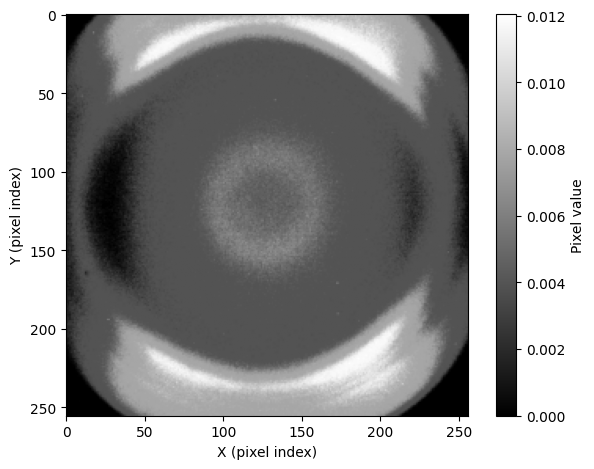

In [10]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torch
from xflow.data.transform import join_image, torch_to_grayscale, torch_remap_range, torch_load_image, torch_to_tensor, torch_split_width, torch_crop_area, torch_resize
from xflow.utils import plot_image  

# img_path = Path("C:/Users/qiyuanxu/Desktop/CLEAR25_DMD/dataset/1763845226854121500.png")  # <- change this
img_path = Path("C:/Users/qiyuanxu/Documents/DataHub/datasets/2025-11-22/dataset/9/1763845226854121500.png")  # <- change this

image = torch_load_image(str(img_path))
image = torch_to_tensor(image)
right_t, _ = torch_split_width(image, swap=True)
right_t = torch_crop_area(right_t, ([360, 0], [1560, 1200]))
right_t = torch_resize(right_t, (256, 256), interpolation="bilinear")
right_t = torch_to_grayscale(right_t)
right_t = torch_remap_range(right_t)

print("right_t shape:", tuple(right_t.shape), "dtype:", right_t.dtype)

plot_image(right_t)

  basis[0] * 0.00
  basis[1] * 0.00
  basis[2] * 0.00
  basis[3] * 0.00
  basis[4] * 0.00
  basis[5] * 0.00
  basis[6] * 0.00
  basis[7] * 0.00
  basis[8] * 0.00
  basis[9] * 0.00
  basis[10] * 0.00
  basis[11] * 0.00
  basis[12] * 0.00
  basis[13] * 0.00
  basis[14] * 0.00
  basis[15] * 0.00
  basis[16] * 0.00
  basis[17] * 0.00
  basis[18] * 0.00
  basis[19] * 0.00
  basis[20] * 0.00
  basis[21] * 0.00
  basis[22] * 0.00
  basis[23] * 0.00
  basis[24] * 0.00
  basis[25] * 0.00
  basis[26] * 0.00
  basis[27] * 0.00
  basis[28] * 0.00
  basis[29] * 0.00
  basis[30] * 0.00
  basis[31] * 0.00
  basis[32] * 0.00
  basis[33] * 0.00
  basis[34] * 0.00
  basis[35] * 0.00
  basis[36] * 0.00
  basis[37] * 0.00
  basis[38] * 0.00
  basis[39] * 0.00
  basis[40] * 0.00
  basis[41] * 0.00
  basis[42] * 0.00
  basis[43] * 0.00
  basis[44] * 0.00
  basis[45] * 0.00
  basis[46] * 0.00
  basis[47] * 0.00
  basis[48] * 0.00
  basis[49] * 0.00
  basis[50] * 0.00
  basis[51] * 0.00
  basis[52] * 0.00
  b

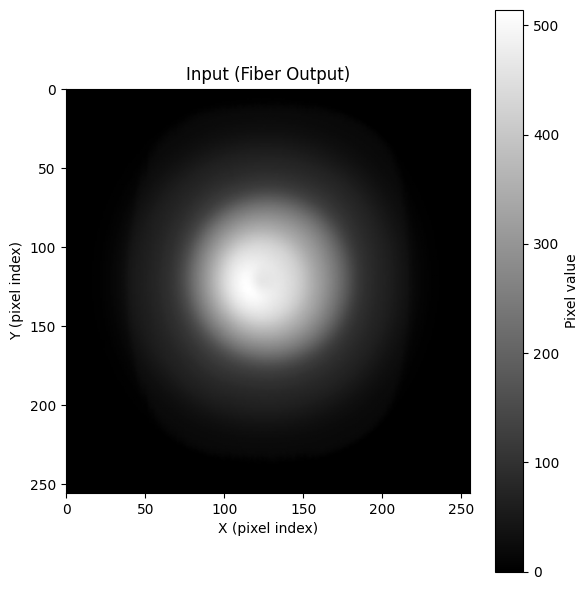

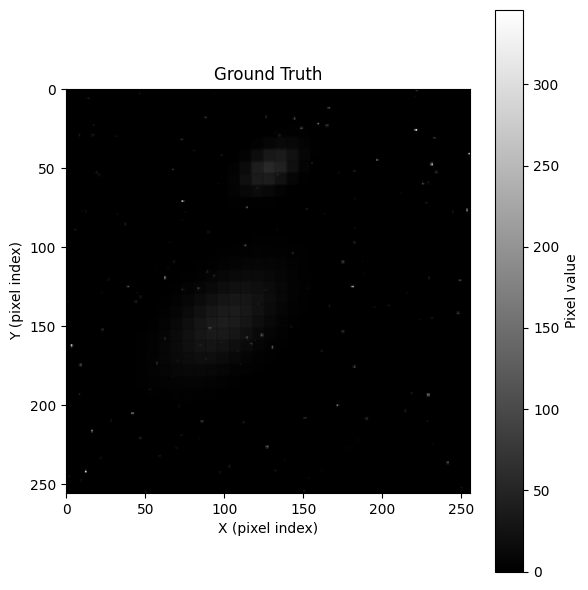

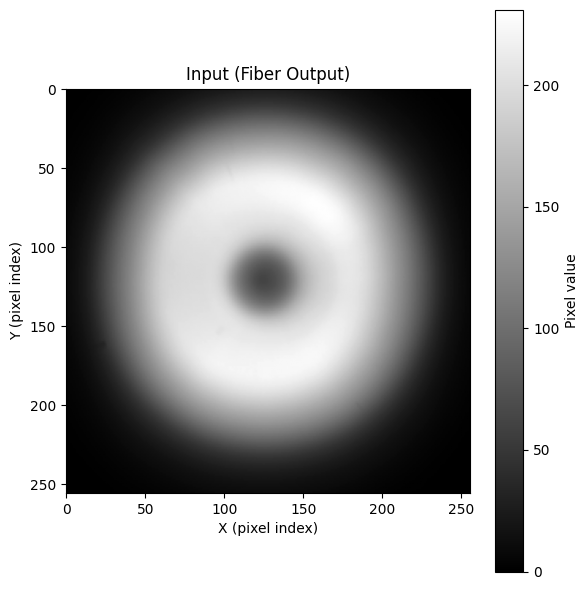

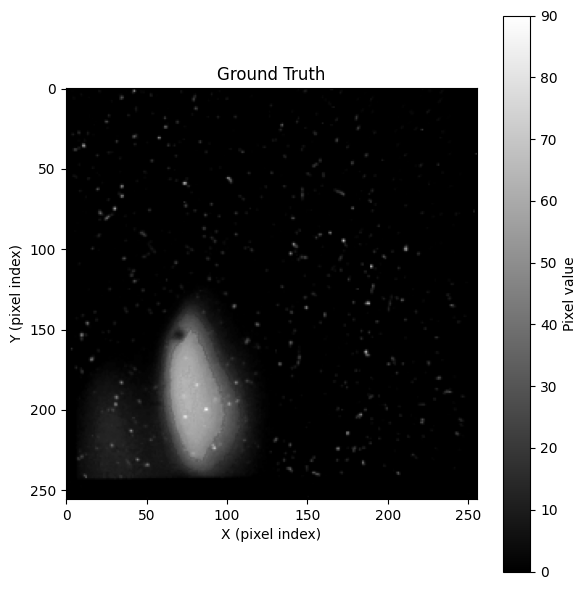

In [28]:
# Each dataset (train, val, test) takes some random samples for visualization and sanity check 
# Specifically for the training set, also print out the basis combination info
for sample in train_pipeline:
    record = combinator.last_record
    # print(f"Indices: {record.indices}")
    # print(f"Coefficients: {record.coefficients}")
    # Get the actual basis components
    for idx, coef in zip(record.indices, record.coefficients):
        basis_item = train_pipeline.get_basis(idx)
        print(f"  basis[{idx}] * {coef:.2f}")
    left_parts, right_parts = sample
    plot_image(left_parts[0], title="Input (Fiber Output)", figsize=(6,6))
    plot_image(right_parts[0], title="Ground Truth", figsize=(6,6))
    break

for left_parts, right_parts in val_pipeline:
    plot_image(left_parts[0], title="Input (Fiber Output)", figsize=(6,6))
    plot_image(right_parts[0], title="Ground Truth", figsize=(6,6))
    break
# for left_parts, right_parts in test_pipeline:
#     plot_image(left_parts[0], title="Input (Fiber Output)", figsize=(6,6))
#     plot_image(right_parts[0], title="Ground Truth", figsize=(6,6))
#     break


# TODO: push the pipeline and run on HPC/GPU, but first run locally to test the full pipeline

# TODO: Clip maximum value to 255
# TODO: remove severely saturated samples in testset
# TODO: index scale factor is not totally correct, since the peak intensity of basis is not exactly 1.0
# TODO: noise problem emerges, when stacking too many basis patterns together, need to investigate further
# TODO: generated image need postprocess or quality gate to deal like noise spark pixel value go over 1000
# TODO: develop another module or try to modify the combinator? so that given arbitrary target image, I be able to visualize the basis combination results.

# Scope 2 - Real data only with data augmentation pipeline (super position)
Create such ready to use dataset for training and evaluation

# Visualization (temp)

In [ ]:
from xflow.utils.visualization import stack_log_remap, stack_linear_clip
stacked = stack_log_remap([x[1] for x in results])
plot_image(stacked)

stacked = stack_linear_clip([x[1] for x in results])
plot_image(stacked)

In [ ]:
from __future__ import annotations
from typing import Tuple, Optional
import numpy as np

Point = Tuple[float, float]


def _min_mass_segment(weights: np.ndarray, frac: float, eps: float = 1e-12) -> Tuple[int, int]:
    """
    Smallest contiguous index range [i, j) whose sum >= frac * total.
    Returns (i, j) with j exclusive.
    """
    w = np.asarray(weights, dtype=float)
    w = np.clip(w, 0.0, None)
    n = w.size
    if n == 0:
        raise ValueError("Empty weights.")
    total = float(w.sum())
    if total <= eps:
        # No mass -> return full range
        return 0, n

    target = frac * total
    best_i, best_j = 0, n
    best_len = n + 1

    j = 0
    s = 0.0
    for i in range(n):
        while j < n and s < target:
            s += w[j]
            j += 1
        if s >= target:
            if (j - i) < best_len:
                best_len = j - i
                best_i, best_j = i, j
        s -= w[i]

    return best_i, best_j


def _clamp_interval(a: float, b: float, lo: float = 0.0, hi: float = 1.0) -> Tuple[float, float]:
    """Clamp [a,b] into [lo,hi] by shifting (keeps length if possible)."""
    length = b - a
    if length >= (hi - lo):
        return lo, hi
    if a < lo:
        b = b + (lo - a)
        a = lo
    if b > hi:
        a = a - (b - hi)
        b = hi
    a = max(lo, a)
    b = min(hi, b)
    return a, b


def square_from_projections(
    img: np.ndarray,
    frac: float,
    *,
    make_square: bool = True,
    channel_reduce: str = "sum",  # "sum" or "mean"
    eps: float = 1e-12,
) -> Tuple[Point, Point]:
    """
    1) Project image onto x and y by summing pixels.
    2) Find minimal contiguous x-interval containing `frac` of x-projection mass,
       and same for y.
    3) Form rectangle. If make_square=True, expand to the smallest axis-aligned square
       that contains that rectangle (centered), clamped to [0,1].

    Returns (top_left, bottom_right) in normalized coords, with (0,0) at top-left.
    """
    if frac > 1.0:
        frac = frac / 100.0
    if not (0.0 < frac <= 1.0):
        raise ValueError("frac must be in (0,1] or (0,100].")

    a = np.asarray(img, dtype=float)
    if a.ndim == 3:
        if channel_reduce == "mean":
            a = a.mean(axis=2)
        elif channel_reduce == "sum":
            a = a.sum(axis=2)
        else:
            raise ValueError("channel_reduce must be 'sum' or 'mean'")
    elif a.ndim != 2:
        raise ValueError("img must be 2D or 3D array")

    # Ensure non-negative "mass"
    a = np.clip(a, 0.0, None)

    H, W = a.shape
    if H == 0 or W == 0:
        raise ValueError("img has zero size")

    proj_x = a.sum(axis=0)  # length W
    proj_y = a.sum(axis=1)  # length H

    ix0, ix1 = _min_mass_segment(proj_x, frac, eps=eps)  # [ix0, ix1)
    iy0, iy1 = _min_mass_segment(proj_y, frac, eps=eps)  # [iy0, iy1)

    # Convert pixel-edge indices to normalized [0,1]
    x0, x1 = ix0 / W, ix1 / W
    y0, y1 = iy0 / H, iy1 / H

    if not make_square:
        return (x0, y0), (x1, y1)

    # Expand rectangle to a square (axis-aligned), centered on the rectangle
    w = x1 - x0
    h = y1 - y0
    side = max(w, h)

    cx = 0.5 * (x0 + x1)
    cy = 0.5 * (y0 + y1)

    sx0, sx1 = cx - 0.5 * side, cx + 0.5 * side
    sy0, sy1 = cy - 0.5 * side, cy + 0.5 * side

    sx0, sx1 = _clamp_interval(sx0, sx1, 0.0, 1.0)
    sy0, sy1 = _clamp_interval(sy0, sy1, 0.0, 1.0)

    return (sx0, sy0), (sx1, sy1)


# Example:
tl, br = square_from_projections(stacked, 0.96)
highlighted = draw_red_square(stacked, tl, br, thickness=2)
plot_image(highlighted)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

a = np.array(results)
hc, vc, hw, vw = a[:, 0], a[:, 1], a[:, 2], a[:, 3]

fig, ax = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

ax[0].scatter(hc, vc, s=5, alpha=0.3)
ax[0].set(xlim=(0, 1), ylim=(0, 1), xlabel="h_centroid", ylabel="v_centroid", title="Centroids")
ax[0].set_aspect("equal")

ax[1].scatter(hw, vw, s=5, alpha=0.3)
ax[1].set(xlim=(0, 1), ylim=(0, 1), xlabel="h_width", ylabel="v_width", title="Widths")
ax[1].set_aspect("equal")

plt.show()

# Backup

In [ ]:
# Connect to database and read image sample paths
# """wednesday chromox"""
# dirs = config["paths"]["chromox_2025-11-19"] 
# query = """
# SELECT 
#     image_path
# FROM 
#     mmf_dataset_metadata 
# WHERE 
#     batch IN (10, 11, 12)
# --LIMIT 20
# """

"""Friday Chromox"""
dirs = config["paths"]["chromox_2025-11-21"] 
query = """
SELECT 
    image_path
FROM 
    mmf_dataset_metadata 
WHERE
    batch IN (1, 2, 3)
--LIMIT 20
"""

# """Saturday Chromox"""
# dirs = config["paths"]["chromox_2025-11-22-morning"] 
# query = """
# SELECT 
#     image_path
# FROM 
#     mmf_dataset_metadata 
# WHERE
#     batch IN (10, 11, 12)
# --LIMIT 20
# """

db_path = f"{dirs}/db/dataset_meta.db"
realbeam_provider = SqlProvider(
    sources={"connection": db_path, "sql": query}, output_config={'list': "image_path"}
)
image_paths = realbeam_provider()
print(f"Found {len(image_paths)} entries in the database.")